In [71]:
import os
os.system('clear')

import numpy as np
import pandas as pd
import datetime

from termcolor import colored
from SecretColors.palette import Palette
material = Palette("material", color_mode = 'hexa')

hex_salmon = '#F68F83'
hex_gold = '#BC9661'
hex_indigo = '#2D2E5F'
hex_maroon = '#8C4750'
hex_white = '#FAFAFA'
hex_blue = '#7EB5D2'

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
mpl.rcParams['font.family'] = 'SF Compact Text'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[hex_indigo, hex_salmon, hex_maroon])
mpl.rcParams["figure.titlesize"] = 'large'
mpl.rcParams["figure.titleweight"] = 'semibold'

print('Finished')

Finished


In [72]:
# flist = [f for f in sorted(os.listdir("./raw")) if not (f.startswith('.') or f.startswith('~'))]

# print(flist)

# for filename in flist:
#     print(filename)
#     y = int(filename[:4])
#     print(y)
#     if y == 2019:
#         df = pd.read_excel(f"./raw/{filename}", header = None, skip_blank_lines=True, decimal=',', thousands='.')
#         df = df.replace('Instrument code', 'Instrumentcode')
#         df = df.replace('Contract type', 'Contracttype')
#         df = df.dropna(how = 'all', axis = 0)
#         df = df.dropna(how = 'all', axis = 1)
#         df = df.reset_index(drop = True)
        
#         df.columns = df.iloc[0]
#         df = df.drop(0)

#         df1 = df[~df['Instrumentcode'].str.contains('NL ID ')]
#         df2 = df[df['Instrumentcode'].str.contains('NL ID ')]

#         df1['Date'] = pd.to_datetime(df1['Instrumentcode'].str[:7], format = '%d%b%y')
#         df2['Date'] = pd.to_datetime(df2['Instrumentcode'].str.replace("NL ID ", "").str[:7], format = '%y%b%d')
#         df = pd.concat([df1, df2]).sort_index()

#         df = df[df['Date'].dt.year == y]

#         df['Time'] = (df['Instrumentcode'].str[-2:].astype('int64') - 1).astype('str')
#         df['Date'] = pd.to_datetime(df['Date'].dt.strftime("%Y-%m-%d") + ' ' + df['Time'].astype(str) + ':00:00')

#         df['Price'] = df['Price'].astype('float')
#         df['Volume'] = df['Volume'].astype('float')

#         df.to_pickle(f"./{os.path.splitext(filename)[0]}.pkl")

In [73]:
flist = [f for f in sorted(os.listdir("./close")) if not (f.startswith('.') or f.startswith('~'))]

print(flist)
big_df = pd.DataFrame()

for filename in flist:
    print(filename)
    df = pd.read_excel(f"./close/{filename}", skip_blank_lines=True, decimal=',', thousands='.')
    # df = df.replace('Instrument code', 'Instrumentcode')
    # df = df.replace('Contract type', 'Contracttype')
    df['period_from'] = df['period_from'].astype('str')
    df['period_until'] = df['period_until'].astype('str')
    df['period_from'] = df['period_from'].str[-8:]
    df['period_until'] = df['period_until'].str[-8:]
    df = df.dropna(how = 'all', axis = 0)
    df = df.dropna(how = 'all', axis = 1)
    df = df.reset_index(drop = True)
    df['Time'] = df['period_from'].str[0:2]
    df['Date'] = pd.to_datetime(df['datum'].dt.strftime("%Y-%m-%d") + ' ' + df['Time'] + ':00:00')
    print(df)
    df_group3 = df.drop([], axis=1).groupby([(df['Date'].dt.year), (df['Date'].dt.month), (df['Date'].dt.day), (df['Date'].dt.hour)]).mean()
    df_group3['Date'] = df_group3.index
    df_group3['Date'] = pd.to_datetime(df_group3['Date'], format='(%Y, %m, %d, %H)')
    df_group3 = df_group3.set_index(pd.DatetimeIndex(df_group3['Date']))
    print(df_group3)

    big_df['Imbalance'] = df_group3['take_from_system_EUR_MWh']

['Export_01-01-2019_01-01-2020.xls']
Export_01-01-2019_01-01-2020.xls
           datum  ptu period_from period_until upward_incident_reserve  \
0     2019-01-01    1    00:00:00     00:15:00                     NaN   
1     2019-01-01    2    00:15:00     00:30:00                     NaN   
2     2019-01-01    3    00:30:00     00:45:00                     NaN   
3     2019-01-01    4    00:45:00     01:00:00                     NaN   
4     2019-01-01    5    01:00:00     01:15:00                     NaN   
...          ...  ...         ...          ...                     ...   
35131 2020-01-01   92    22:45:00     23:00:00                     NaN   
35132 2020-01-01   93    23:00:00     23:15:00                     NaN   
35133 2020-01-01   94    23:15:00     23:30:00                     NaN   
35134 2020-01-01   95    23:30:00     23:45:00                     NaN   
35135 2020-01-01   96    23:45:00     00:00:00                     NaN   

      downward_incident_reserve  upward_d

0                        Price     Volume                Date
Date Date Date Date                                          
2019 1    1    0     80.784098   7.849180 2019-01-01 00:00:00
               1     56.062500  17.708333 2019-01-01 01:00:00
               2     47.276444  10.628889 2019-01-01 02:00:00
               3     46.745000   8.963333 2019-01-01 03:00:00
               4     40.400361   7.712048 2019-01-01 04:00:00
...                        ...        ...                 ...
     7    10   18    34.000000   0.100000 2019-07-10 18:00:00
               19    34.000000   0.100000 2019-07-10 19:00:00
               20    34.000000   0.100000 2019-07-10 20:00:00
               21    34.000000   0.100000 2019-07-10 21:00:00
               22    34.000000   0.100000 2019-07-10 22:00:00

[4578 rows x 3 columns]

...

Year: 2019

Price: 44519770 Euro
Volume: 5337029 MWh



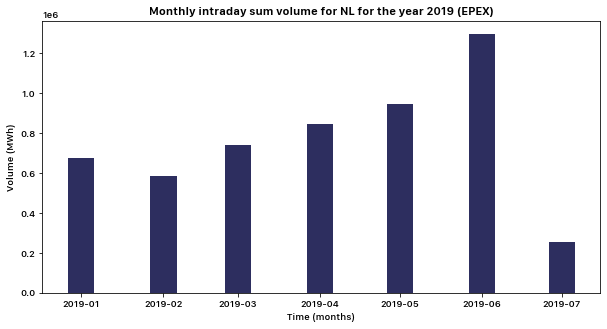

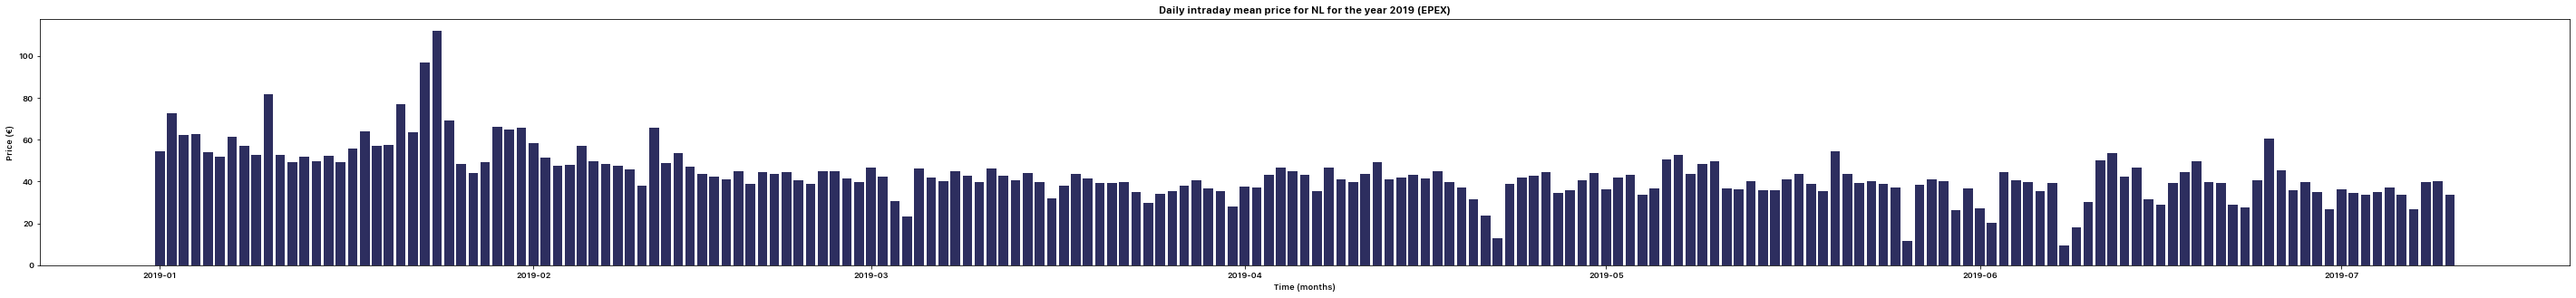


...

Period: 2019–2019
Price: 44519770 Euro
Volume: 5337029 MWh

...

                     Imbalance      Price  Percentage
Date                                                 
2019-01-01 00:00:00    44.6850  80.784098    0.807857
2019-01-01 01:00:00    36.4850  56.062500    0.536590
2019-01-01 02:00:00    42.4925  47.276444    0.112583
2019-01-01 03:00:00    40.0825  46.745000    0.166220
2019-01-01 04:00:00    30.5675  40.400361    0.321677
...                        ...        ...         ...
2020-01-01 19:00:00   105.4125        NaN         NaN
2020-01-01 20:00:00    -1.6800        NaN         NaN
2020-01-01 21:00:00    87.3025        NaN         NaN
2020-01-01 22:00:00    62.4525        NaN         NaN
2020-01-01 23:00:00    28.3000        NaN         NaN

[8784 rows x 3 columns]
0               Instrumentcode  Side  Price  Volume Contracttype  \
1        NL ID 19JAN01 - 1H-01   buy  78.00    10.0         Spot   
2        NL ID 19JAN01 - 1H-01  sell  78.00    10.0         Spot  

In [74]:
years = ['2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
years = ['2019']
country = 'NL'

dfo = pd.DataFrame()
dfo2 = pd.DataFrame()
price = []
volume = []
breaks = []

for y in years:
    i = years.index(y)

    df = pd.read_pickle(f"./{y}_Intraday.pkl")

    # df['Price'] = df['Price'].astype('float')
    # df['Volume'] = df['Volume'].astype('float')
    # print(df['Price'])
    # print(df['Volume'])

    df['Creation timestamp (GMT)'] = pd.to_datetime(df['Creation timestamp (GMT)'], format='%d-%m-%Y %H:%M:%S')

    volume_buy = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy', 'Volume'].sum()
    volume_sell = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell', 'Volume'].sum()

    price_buy = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy', 'Price'].sum()
    price_sell = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell', 'Price'].sum()

    df_group = df.drop(['Instrumentcode', 'Contracttype', 'Side'], axis=1).groupby([(df['Date'].dt.year),(df['Date'].dt.month)]).sum()
    df_group['Date'] = df_group.index
    df_group['Date'] = pd.to_datetime(df_group['Date'], format='(%Y, %m)')

    df_group2 = df.drop(['Instrumentcode', 'Contracttype', 'Side'], axis=1).groupby([(df['Date'].dt.year), (df['Date'].dt.month), (df['Date'].dt.day)]).mean()
    df_group2['Date'] = df_group2.index
    df_group2['Date'] = pd.to_datetime(df_group2['Date'], format='(%Y, %m, %d)')

    df_group3 = df.drop(['Instrumentcode', 'Contracttype', 'Side'], axis=1).groupby([(df['Date'].dt.year), (df['Date'].dt.month), (df['Date'].dt.day), (df['Date'].dt.hour)]).mean()
    df_group3['Date'] = df_group3.index
    df_group3['Date'] = pd.to_datetime(df_group3['Date'], format='(%Y, %m, %d, %H)')
    print(df_group3)

    df_group = df_group.set_index(pd.DatetimeIndex(df_group['Date']))
    df_group2 = df_group2.set_index(pd.DatetimeIndex(df_group2['Date']))
    df_group3 = df_group3.set_index(pd.DatetimeIndex(df_group3['Date']))

    dfo = dfo.append(df_group, ignore_index = False)
    dfo2 = dfo2.append(df, ignore_index = False)
    breaks.append(len(dfo))

    price.append(df['Price'].sum())
    volume.append(df['Volume'].sum())
    
    print('')
    print(colored('...','white'))
    print('')
    print(colored(f'Year: {y}', 'blue'))
    print('')
    print(colored(f'Price: {int(round(price[i]))} Euro', 'blue'))
    print(colored(f'Volume: {int(round(volume[i]))} MWh', 'blue'))
    print('')

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(df_group['Date'], df_group['Volume'], width=10)
    ax.set_title(f'Monthly intraday sum volume for {country} for the year {y} (EPEX)')
    ax.set_xlabel(r'Time (months)')
    ax.set_ylabel(r'Volume (MWh)')
    plt.show()

    fig, ax = plt.subplots(figsize=(50, 5))
    ax.bar(df_group2['Date'], df_group2['Price'])
    ax.set_title(f'Daily intraday mean price for {country} for the year {y} (EPEX)')
    ax.set_xlabel(r'Time (months)')
    ax.set_ylabel(r'Price (€)')
    plt.show()

print('')
print(colored('...','white'))
print('')
print(colored(f'Period: {years[0]}–{years[-1]}', 'blue'))
print(colored(f'Price: {int(round(sum(price)))} Euro', 'blue'))
print(colored(f'Volume: {int(round(sum(volume)))} MWh', 'blue'))
print('')
print(colored('...','white'))
print('')

big_df = big_df.merge(df_group3['Price'], how='outer', left_index=True, right_index=True)
big_df['Percentage'] = np.divide(np.subtract(big_df['Price'], big_df['Imbalance']), big_df['Imbalance'])
print(big_df)

df['Time to delivery'] = df['Date'] - df['Creation timestamp (GMT)']
df['Time to delivery'] = df['Time to delivery'] / np.timedelta64(1, 'h')
# df['Time to delivery'] = (df['Date'] - df['Creation timestamp (GMT)']).astype('timedelta64[h]')
original_dates = df
print(original_dates)

Text(0, 0.5, 'Percentage (%)')

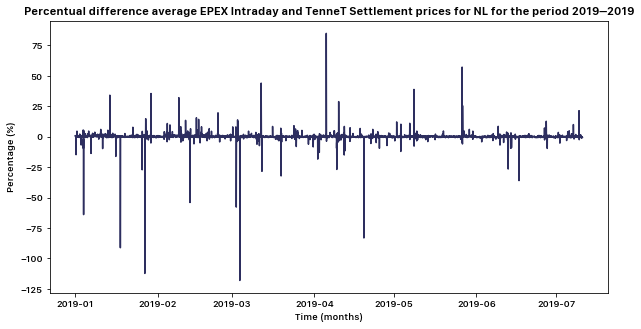

In [75]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(big_df.index, big_df['Percentage'], width=20)
# ax.set_title(f'Percentual difference average EPEX Intraday and TenneT Settlement prices for {country} for the period {years[0]}–{years[-1]}')
# ax.set_xlabel(r'Time (months)')
# ax.set_ylabel(r'Percentage (%)')

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(big_df.index, big_df['Percentage'])
ax.set_title(f'Percentual difference average EPEX Intraday and TenneT Settlement prices for {country} for the period {years[0]}–{years[-1]}')
ax.set_xlabel(r'Time (months)')
ax.set_ylabel(r'Percentage (%)')

Text(0, 0.5, 'Volume (MWh)')

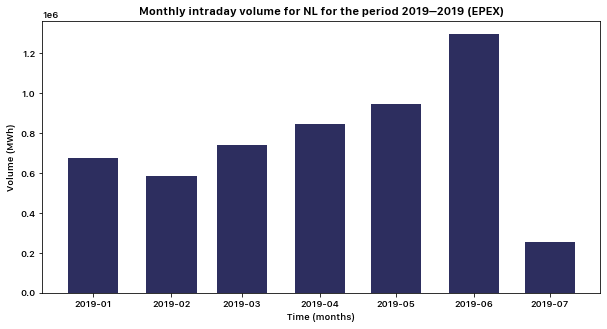

In [76]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(dfo['Date'], dfo['Volume'], width=20)
ax.set_title(f'Monthly intraday volume for {country} for the period {years[0]}–{years[-1]} (EPEX)')
ax.set_xlabel(r'Time (months)')
ax.set_ylabel(r'Volume (MWh)')

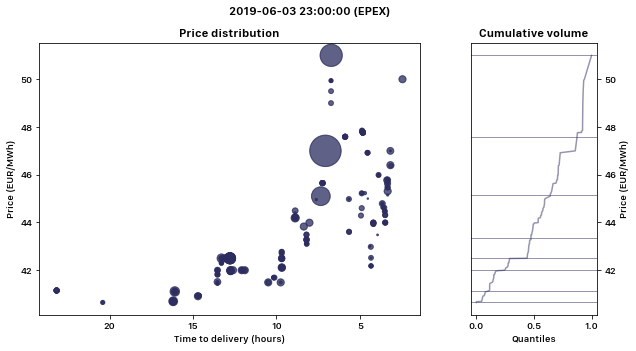

In [83]:
datetime_of_interest = '2019-06-03 23:00:00'
filtered_dates = pd.DataFrame()
filtered_dates = original_dates.loc[original_dates["Date"] == datetime_of_interest]
filtered_dates = original_dates.loc[original_dates["Date"] == datetime_of_interest]

filtered_dates['Volume_weighted'] = filtered_dates['Price'] * filtered_dates['Volume']
filtered_dates['Cumulative volume'] = ''
filtered_dates['Relative volume'] = ''

volume_tot = filtered_dates['Volume'].sum()

df = filtered_dates
for idx, row in df.iterrows():
    df['Cumulative volume'][idx] = df.loc[df['Price'] <= df['Price'][idx]]['Volume'].sum()
    df['Relative volume'][idx] = df['Cumulative volume'][idx] / volume_tot

quantiles = [0, 10, 25, 45, 55, 75, 90, 100]
quantiles_val = list()
quantiles_idx = list()
for q in quantiles:
    quantiles_val.append(filtered_dates['Price'].quantile(q/100))
    quantiles_idx.append(f'Q{q}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})
plt.suptitle(f'{datetime_of_interest} (EPEX)')

x = filtered_dates['Time to delivery']
y = filtered_dates['Price']
ax1.scatter(x, y, s=filtered_dates['Volume'].apply(lambda x: x*5), alpha=0.5)
ax1.set_xlim(x.min() - 0.05 * (x.max() - x.min()), x.max() + 0.05 * (x.max() - x.min()))
ax1.set_ylim(y.min() - 0.05 * (y.max() - y.min()), y.max() + 0.05 * (y.max() - y.min()))
ax1.set_title(f'Price distribution')
ax1.set_xlabel(r'Time to delivery (hours)')
ax1.set_ylabel(r'Price (EUR/MWh)')
ax1.invert_xaxis()

x = filtered_dates.sort_values('Price')['Relative volume']
y = filtered_dates.sort_values('Price')['Price']
[ax2.axhline(q, linewidth=1, alpha=0.5) for q in quantiles_val]
ax2.plot(x, y, alpha=0.5)
ax2.set_xlim(x.min() - 0.05 * (x.max() - x.min()), x.max() + 0.05 * (x.max() - x.min()))
ax2.set_ylim(y.min() - 0.05 * (y.max() - y.min()), y.max() + 0.05 * (y.max() - y.min()))
ax2.set_title(f'Cumulative volume')
ax2.set_xlabel(r'Quantiles')
ax2.set_ylabel(r'Price (EUR/MWh)')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")